# Prediction of Blood Donations using Logistic Regression Classifier

# Introduction

Blood transfusion saves lives - from replacing lost blood during major surgery or a serious injury to treating various illnesses and blood disorders. Ensuring that there's enough blood in supply whenever needed is a serious challenge for the health professionals. According to WebMD, "about 5 million Americans need a blood transfusion every year".

The dataset is from a mobile blood donation vehicle in Taiwan. The Blood Transfusion Service Center drives to different universities and collects blood as part of a blood drive. We want to predict whether or not a donor will give blood the next time the vehicle comes to campus.



# Inspecting transfusion DataFrame
RFM stands for Recency, Frequency and Monetary Value and it is commonly used in marketing for identifying your best customers. In the case case, the customers are blood donors.

RFMTC is a variation of the RFM model. Below is a description of what each column means in our dataset:

- R (Recency - months since the last donation)
- F (Frequency - total number of donation)\
- M (Monetary - total blood donated in c.c.)\
- T (Time - months since the first donation)\
- a binary variable representing whether he/she donated blood in March 2007 (1 stands for donating blood; 0 stands for not donating blood)\

It looks like every column in our DataFrame has the numeric type, which is exactly what we want when building a machine learning model. Let's verify our hypothesis.

In [1]:
#import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import linear_model

# Loading the transfusion dataset

In [2]:
path=r'C:\Users\val-c\Desktop\transfusion\transfusion.csv'
trans_fu=pd.read_csv(path)
trans_fu.head(n=6)

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),whether he/she donated blood in March 2007
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0
5,4,4,1000,4,0


In [4]:
#Explore dataset
#trans_fu[:: 1]
print('(rows,cols) =',trans_fu.shape)

(rows,cols) = (748, 5)


In [5]:
#check for missing values in the dataset
trans_fu.isna().sum().to_frame('Total')

,Total
Recency (months),0
Frequency (times),0
Monetary (c.c. blood),0
Time (months),0
whether he/she donated blood in March 2007,0


In [6]:
# Print a concise summary of transfusion DataFrame
trans_fu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column                                      Non-Null Count  Dtype
---  ------                                      --------------  -----
 0   Recency (months)                            748 non-null    int64
 1   Frequency (times)                           748 non-null    int64
 2   Monetary (c.c. blood)                       748 non-null    int64
 3   Time (months)                               748 non-null    int64
 4   whether he/she donated blood in March 2007  748 non-null    int64
dtypes: int64(5)
memory usage: 29.3 KB


In [7]:
# Rename target column as 'target' for brevity
trans_fu.rename(
    columns={'whether he/she donated blood in March 2007': 'target'},
    inplace=True
)

# Print out the first 2 rows
trans_fu.head(2)

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),target
0,2,50,12500,98,1
1,0,13,3250,28,1


In [8]:
#statistics of the attributes
dist=trans_fu.describe().transpose()
dist

,count,mean,std,min,25%,50%,75%,max
Recency (months),748.0,9.506684,8.095396,0.0,2.75,7.0,14.0,74.0
Frequency (times),748.0,5.514706,5.839307,1.0,2.00,4.0,7.0,50.0
Monetary (c.c. blood),748.0,1378.676471,1459.826781,250.0,500.00,1000.0,1750.0,12500.0
Time (months),748.0,34.282086,24.376714,2.0,16.00,28.0,50.0,98.0
target,748.0,0.237968,0.426124,0.0,0.00,0.0,0.0,1.0


# Checking target incidence


We want to predict whether or not the same donor will give blood the next time the vehicle comes to campus. The model for this is a binary classifier, meaning that there are only 2 possible outcomes:

0 - the donor will not give blood
1 - the donor will give blood
Target incidence is defined as the number of cases of each individual target value in a dataset. That is, how many 0s in the target column compared to how many 1s? Target incidence gives us an idea of how balanced (or imbalanced) is our dataset.

In [9]:
# Print target incidence proportions, rounding output to 3 decimal places
trans_fu.target.value_counts(normalize=True).round(3)

0    0.762
1    0.238
Name: target, dtype: float64

# Splitting the dataset into train and test sets

In [10]:
# Split transfusion DataFrame into
# X_train, X_test, y_train and y_test datasets,
# stratifying on the `target` column
X_train, X_test, y_train, y_test = train_test_split(
    trans_fu.drop(columns='target'),
    trans_fu.target,
    test_size=0.25,
    random_state=42,
    stratify=trans_fu.target
)

# Print out the first 2 rows of X_train
X_train.head(2)

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months)
334,16,2,500,16
99,5,7,1750,26


# Log normalization

Monetary (c.c. blood)'s variance is very high in comparison to any other column in the dataset. This means that, unless accounted for, this feature may get more weight by the model (i.e., be seen as more important) than any other feature.

Correcting for high variance is called normalization. It is one of the possible transformations you do before training a model. 

One way to correct for high variance is to use log normalization.

In [11]:
# Import numpy
import numpy as np

# Copy X_train and X_test into X_train_normed and X_test_normed
X_train_normed, X_test_normed = X_train.copy(), X_test.copy()

# Specify which column to normalize
col_to_normalize = 'Monetary (c.c. blood)'

# Log normalization
for df_ in [X_train_normed, X_test_normed]:
    # Add log normalized column
    df_['monetary_log'] = np.log(df_[col_to_normalize])
    # Drop the original column
    df_.drop(columns=col_to_normalize, inplace=True)

# Check the variance
X_train_normed.var().round(3)

Recency (months)      66.929
Frequency (times)     33.830
Time (months)        611.147
monetary_log           0.837
dtype: float64

# Train , predict & evaluate

In [12]:
# Instantiate LogisticRegression
logreg = linear_model.LogisticRegression(
    solver='liblinear',
    random_state=42
)

# Train the model
logreg.fit(X_train_normed, y_train)

# AUC score for logreg_ model
logreg_auc_score = roc_auc_score(y_test, logreg.predict_proba(X_test_normed)[:, 1])
print(f'\nAUC score: {logreg_auc_score:.4f}')


AUC score: 0.7891


In [13]:
#import further libraries
from sklearn import metrics
import matplotlib.pyplot as plt

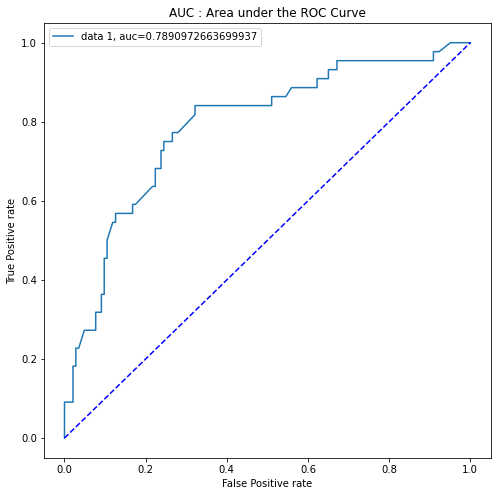

In [14]:
# predict and evaluate model 
y_pred_proba =logreg.predict_proba(X_test_normed)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.figure(figsize=(8,8))
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.plot([0, 1], [0, 1], 'b--')
plt.legend(loc=2)
plt.ylabel('True Positive rate')
plt.xlabel('False Positive rate')
plt.title('AUC : Area under the ROC Curve')
plt.show()

In [17]:
import pickle

In [18]:
pickle.dump(logreg, open('logreg.pkl', 'wb'))

# Summary

# AREA UNDER THE ROC CURVE
AUC is an effective way to summarize the overall diagnostic accuracy of the test. It takes values from 0 to 1, where a value of 0 indicates a perfectly inaccurate test and a value of 1 reflects a perfectly accurate test. AUC can be computed using the trapezoidal rule.3 In general, 
an AUC of 0.5 suggests no discrimination (i.e., ability to diagnose patients with and without the disease or condition based on the test), 0.7 to 0.8 is considered acceptable, 0.8 to 0.9 is considered excellent, and more than 0.9 is considered outstanding.

Moreso, an ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters:

True Positive(TP) Rate\
False Positive(FP) Rate


Studies designed to measure the performance of diagnostic tests are important for patient care and health care costs. ROC curves are a useful tool in the assessment of the performance of a diagnostic test over the range of possible values of a predictor variable